In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = [p[0]]
    for t in range(1, T):
        hmax.append(np.nanmax([p[t], hmax[t - 1]]))
    dd = [p[t] / hmax[t] - 1 for t in range(T)]

    return dd


def cal_period_perf_indicator(adjnav):
    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])
        res = res.applymap(float_to_percent)
        return res
    ret = adjnav.pct_change()
    annret = (adjnav[-1] / adjnav[0]) ** (242/len(adjnav)) - 1 # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]

def datestr2dtdate(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()

# Define a formatting function to convert float to percentage
def float_to_percent(x):
    return "{:.2%}".format(x)

def date_count_in_month(dates):
    # 计算日期序列中每个日期在所在月中的序数
    cur_count = 1
    counts = [cur_count]
    for i in range(1,len(dates)):
        if dates[i].month == dates[i-1].month:
            cur_count = cur_count + 1
        else:
            cur_count = 1
        counts.append(cur_count)
    return counts


# Rotation Logic combined with RRG Plot
def calc_jdk_rs_ratio(data: pd.Series) -> pd.Series:
    """
    Calculate the JDK RS Ratio.
    Parameters:
    data (pd.Series): A pandas series containing the data to calculate the ratio from.
    Returns:
    pd.Series: A pandas series containing the JDK RS Ratio.
    """
    # Calculate the 50-day and 200-day moving averages
    ma_50 = data.rolling(window=50).mean()
    ma_200 = data.rolling(window=200).mean()

    # Calculate the JDK RS Ratio
    jdk_rs_ratio = ma_50 / ma_200 - 1

    return jdk_rs_ratio


def calc_jdk_rs_momentum(jdk_rs_ratio: pd.Series) -> pd.Series:
    """
    Calculate the JDK RS Momentum.
    Parameters:
    jdk_rs_ratio (pd.Series): A pandas series containing the JDK RS Ratio to calculate the momentum from.
    Returns:
    pd.Series: A pandas series containing the JDK RS Momentum.
    """
    # Calculate the 20-day momentum
    jdk_rs_momentum = jdk_rs_ratio.diff(20)

    return jdk_rs_momentum


def calculate_jdk_rs(data: pd.Series) -> pd.Series:
    """
    Calculate the JDK RS Ratio and Momentum.
    Parameters:
    data (pd.Series): A pandas series containing the data to calculate the ratio and momentum from.
    Returns:
    pd.Series: A pandas series containing the JDK RS Ratio and Momentum.
    """
    if len(data) < 200:
        raise ValueError("Input data must have at least 200 data points")

    # Calculate the JDK RS Ratio
    jdk_rs_ratio = calc_jdk_rs_ratio(data)

    # Calculate the JDK RS Momentum
    jdk_rs_momentum = calc_jdk_rs_momentum(jdk_rs_ratio)

    # Concatenate the JDK RS Ratio and Momentum into a single series
    jdk_rs = pd.concat([jdk_rs_ratio, jdk_rs_momentum], axis=1)
    jdk_rs.columns = ['JDK RS Ratio', 'JDK RS Momentum']

    return jdk_rs

In [2]:
from sklearn.linear_model import LinearRegression

def LR_Prediction(ticker,index_data):
    # Training Linear Regression based on 2018-2022 data
    start_date = datetime.date(2015,1,1)
    end_date = datetime.date(2022,12,31)
    index_data =  index_data[index_data.index>=start_date]

    index_id = ticker

    df = index_data.loc[:,[index_id]]
    # adding feature
    df['ret'] = df[index_id].pct_change()
    df['asset'] = (1+df['ret']).cumprod().fillna(1)
    df = df.rename({index_id:'Price'},axis=1)
    df['SMA_10'] = df['Price'].rolling(window=10).mean()
    df['SMA_50'] = df['Price'].rolling(window=50).mean()
    df['Forecast'] = df['Price'].shift(-1) # Dependent variable
    df = df.loc[df[['SMA_10', 'SMA_50']].dropna().index]
    X = df[['SMA_10', 'SMA_50']] # Independent variables
    y = df['Forecast'] # Dependent variable

    # Split data into training and test sets
    train_size = int(len(df[df.index<=end_date]) * 0.8)
    test_size = int(len(df[df.index<=end_date]))
    train_X, train_y = X[:train_size], y[:train_size]
    test_X, test_y = X[train_size:test_size], y[train_size:test_size]

    # Fit linear regression model to training data
    lr = LinearRegression()
    lr.fit(train_X, train_y)

    # Make predictions on test data
    y_pred = lr.predict(test_X)

    # Get the Robustnes
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    # Evaluate performance on testing dataset
    r2 = r2_score(test_y, y_pred)
    mae = mean_absolute_error(test_y, y_pred)
    mse = mean_squared_error(test_y, y_pred)
    print(f"{ticker} test dataset result:")
    print("R2 score on testing dataset: ", r2)
    print("MAE on testing dataset: ", mae)
    print("MSE on testing dataset: ", mse)

    # Add in prediction
    df['Predicted'] = lr.predict(np.array(X).reshape(-1, len(X.columns)))
    return df

# LR

SPY test dataset result:
R2 score on testing dataset:  0.8877731376710782
MAE on testing dataset:  7.501240043773529
MSE on testing dataset:  91.72730332719098


/Users/noahyao/miniforge3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/bp/qc2h9tl16ygf22xhvh6y6xk80000gn/T/ipykernel_15907/795832973.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Last Price'] = data['Price'].shift(1)


,AnnRet,AnnVol,SR,MaxDD,Calmar
asset,-6.27%,21.59%,-29.04%,-26.29%,-23.85%
stgy,4.29%,17.24%,24.88%,-17.73%,24.19%


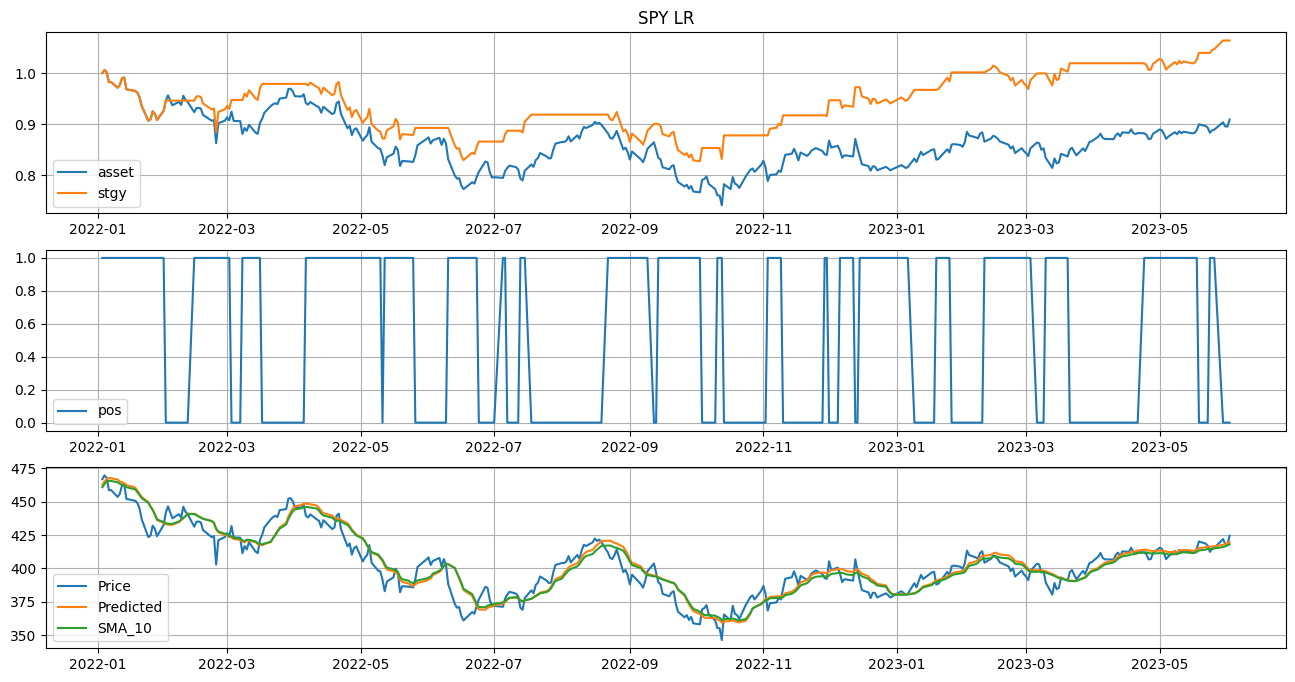

In [78]:
# Set up long/short strategy based on predicted returns
prices = pd.read_csv('../Data/USD ETFs_open.csv')
prices = prices.set_index('datetime')
prices.index = [datestr2dtdate(e) for e in prices.index]

ticker = 'SPY'
start_date = datetime.date(2022,1,1)
df = LR_Prediction(ticker,prices)

data = df[df.index>start_date]
data['Last Price'] = data['Price'].shift(1)
signal = 1
price = data['Price'].tolist()[0]
def strategy(x):
    global signal
    global price
    x['Buy/Sold'] = price
    x['pos'] = signal
    if signal == 0:
        ratio = x['Price'] - x['Predicted']
        if ratio< -2 :
            signal = 1 
            price = x['Price']
            x['pos'] = signal
            x['Buy/Sold'] = price
    if signal == 1:
        if x['Price'] / x['Predicted'] >=1.01 or x['Price'] / price <= 0.9:
            signal = 0
            price = x['Price']
            x['Buy/Sold'] = price
            x['pos'] = signal
    return x
data = data.apply(strategy,axis=1)
data['ret'] = data['Price'].pct_change()
data['asset'] = (1+data['ret']).cumprod().fillna(1)
data['stgy_ret'] = data['Price'].pct_change() * data['pos'].shift(1)
# df['stgy_ret'] = df['ret'] * df['pos']
data['stgy'] = (1+data['stgy_ret']).cumprod().fillna(1)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(3,1,1)
data.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title=f'{index_id} LR')
ax2 = fig.add_subplot(3,1,2)
data.loc[:,['pos']].plot(ax=ax2, grid=True)
ax3 = fig.add_subplot(3,1,3)
data.loc[:,['Price','Predicted','SMA_10']].plot(ax=ax3, grid=True)
res = cal_period_perf_indicator(data.loc[:,['asset','stgy']])
display(res)


# RRG

In [3]:
# Prepare RRG Matrix
prices = pd.read_csv('../Data/USD ETFs_open.csv')
prices = prices.set_index('datetime')
prices.index = [datestr2dtdate(e) for e in prices.index]

SPY test dataset result:
R2 score on testing dataset:  0.8877731376710782
MAE on testing dataset:  7.501240043773529
MSE on testing dataset:  91.72730332719098
SCHE test dataset result:
R2 score on testing dataset:  0.9527236240989845
MAE on testing dataset:  0.5032756377133707
MSE on testing dataset:  0.38529485853413564


/Users/noahyao/miniforge3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/noahyao/miniforge3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,AnnRet,AnnVol,SR,MaxDD,Calmar
SPY,26.83%,15.57%,172.30%,-7.97%,336.75%
SCHE,3.88%,14.48%,26.82%,-11.88%,32.69%
stgy,9.18%,14.29%,64.27%,-10.16%,90.41%


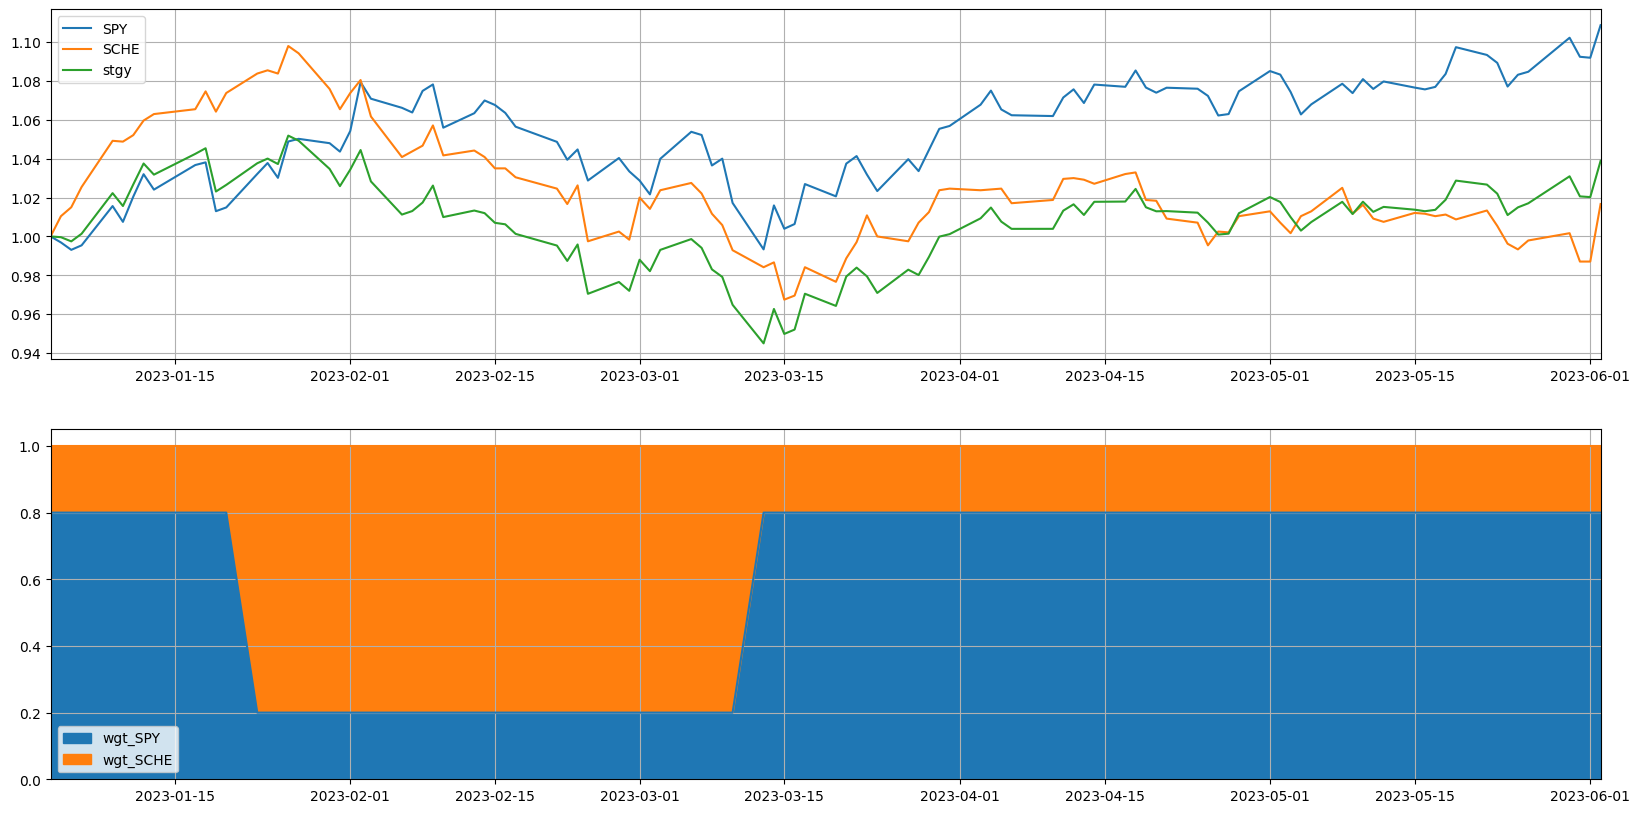

In [92]:
# Linear Regression on Empty position
# Rotation with RRG Signal
ETF1 = 'SPY'
ETF2 = 'SCHE'
weight = 0.8
start_date = datetime.date(2023,1,1)
N = 20
df = prices[[ETF1,ETF2]].copy()

df['rs_ratio'] = df[ETF2] / df[ETF1]
df['jdk_rs_ratio'] = calc_jdk_rs_ratio(df[['rs_ratio']])
df['jdk_rs_momentum'] = calc_jdk_rs_momentum(df[['jdk_rs_ratio']])

data = LR_Prediction(ETF1,prices)
df[f'Predict_{ETF1}'] = data['Predicted']
data = LR_Prediction(ETF2,prices)
df[f'Predict_{ETF2}'] = data['Predicted']

df = df[df.index>start_date]
df[f'ret_{ETF1}'] = df[ETF1].pct_change()
df[f'ret_{ETF2}'] = df[ETF2].pct_change()

signal = {ETF1:1,ETF2:1}
price = {ETF1:df[ETF1].tolist()[0],ETF2:df[ETF2].tolist()[0]}
def strategy(df):
    global wieght
    df[f'wgt_{ETF1}'] = weight
    df[f'wgt_{ETF2}'] = 1 - weight
    if df['jdk_rs_momentum']>0:
        df[f'wgt_{ETF2}'] = weight
        df[f'wgt_{ETF1}'] = 1 - weight
    # Add in LR logic
    global signal
    global price
    for etf in [ETF1,ETF2]:
        if signal[etf] == 0:
            ratio = df[etf] - df[f'Predict_{etf}']
            if ratio< -2 :
                signal[etf] = 1 
                price[etf] = df[etf]
                df[f'wgt_{etf}'] = df[f'wgt_{etf}']*1
        if signal[etf] == 1:
            if df[etf] / price[etf] >=1.01 or df[etf] / price[etf] <= 0.9:
                signal[etf] = 0
                price[etf] = df[etf]
                df[f'wgt_{etf}'] = df[f'wgt_{etf}']*0
                
    return df
df = df.apply(strategy,axis=1)
df['ret_stgy'] = df[f'ret_{ETF1}'] * df[f'wgt_{ETF1}'] + df[f'ret_{ETF2}'] * df[f'wgt_{ETF2}']
df[ETF1] = (1+df[f'ret_{ETF1}']).cumprod().fillna(1)
df[ETF2] = (1+df[f'ret_{ETF2}']).cumprod().fillna(1)
df['stgy'] = (1+df['ret_stgy']).cumprod().fillna(1)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,[ETF1, ETF2, 'stgy']].plot(ax=ax1, grid=True)
plt.xlim(df.index[0],df.index[-1])

ax2 = fig.add_subplot(2,1,2)
df[[f'wgt_{ETF1}', f'wgt_{ETF2}']].plot(ax=ax2, kind='area', stacked=True, grid=True)
plt.xlim(df.index[0],df.index[-1])
    
res = cal_period_perf_indicator(df.loc[:,[ETF1, ETF2, 'stgy']])
res


